In [4]:
import pandas as pd

# 读取 Coroheart_Normal_Values.csv 文件
normal_values = pd.read_csv('output/Coroheart_Normal_Values.csv')

# 提取 itemid 列并转换为字典
itemid_dict = normal_values['itemid'].to_dict()

# 打印 itemid
itemid_list = ', '.join(map(str, itemid_dict.values()))
print(itemid_list)

220546, 220228, 226540, 227457, 220615, 220621, 225624, 227467, 225668, 227442, 220645, 220050, 220051, 220052, 220045, 220210, 223761, 225690, 220603, 220277, 225625, 227456, 227073, 227444, 225634, 225628, 220644, 220587, 227446, 220632


In [7]:
import pandas as pd
from tqdm import tqdm

# 读取 Coroheart_Age_Gender.csv 文件，提取 (subject_id, hadm_id, stay_id)
coroheart_age_gender = pd.read_csv('output/Coroheart_Age_Gender.csv')
valid_combinations = set(zip(coroheart_age_gender['subject_id'], coroheart_age_gender['hadm_id'], coroheart_age_gender['stay_id']))

# 定义需要保留的 itemid 列表
valid_itemids = {
    220546, 220228, 226540, 227457, 220615, 220621, 225624, 227467, 
    225668, 227442, 220645, 220050, 220051, 220052, 220045, 220210, 
    223761, 225690, 220603, 220277, 225625, 227456, 227073, 227444, 
    225634, 225628, 220644, 220587, 227446, 220632
}

# 读取 chartevents.csv 文件
chunk_size = 10**5  # 分块大小
filtered_data = pd.DataFrame()  # 用于存储过滤后的数据

# 计算块数
total_chunks = sum(1 for _ in pd.read_csv('..\chartevents.csv', chunksize=chunk_size))

# 使用 tqdm 显示进度条
with tqdm(total=total_chunks, desc="Processing chartevents") as pbar:
    for chunk in pd.read_csv('..\chartevents.csv', chunksize=chunk_size):
        # 过滤条件：组合 (subject_id, hadm_id, stay_id) 在 valid_combinations 中，itemid 在 valid_itemids 中
        filtered_chunk = chunk[
            chunk.apply(lambda row: (row['subject_id'], row['hadm_id'], row['stay_id']) in valid_combinations, axis=1) &
            chunk['itemid'].isin(valid_itemids)
        ]
        filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)
        pbar.update(1)

# 保存结果到 Coroheart_Targets_Raw.csv
output_file_path_coroheart_targets_raw = 'output/Coroheart_Targets_Raw.csv'
filtered_data.to_csv(output_file_path_coroheart_targets_raw, index=False)

print(f"Coroheart_Targets_Raw.csv 文件已保存到 {output_file_path_coroheart_targets_raw}")

Processing chartevents: 100%|██████████| 4330/4330 [1:26:06<00:00,  1.19s/it]


Coroheart_Targets_Raw.csv 文件已保存到 output/Coroheart_Targets_Raw.csv


: 

In [1]:
import pandas as pd

# 读取 Coroheart_Targets_Raw.csv 文件
coroheart_targets_raw = pd.read_csv('output/Coroheart_Targets_Raw.csv')

# 选择需要保留的列
filtered_data = coroheart_targets_raw[['stay_id', 'charttime', 'itemid', 'value']]

# 保存结果到 Coroheart_Targets_Filter.csv
output_file_path_coroheart_targets_filter = 'output/Coroheart_Targets_Filter.csv'
filtered_data.to_csv(output_file_path_coroheart_targets_filter, index=False)

print(f"Coroheart_Targets_Filter.csv 文件已保存到 {output_file_path_coroheart_targets_filter}")

d:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Coroheart_Targets_Filter.csv 文件已保存到 output/Coroheart_Targets_Filter.csv


In [2]:
import pandas as pd

# 读取 Coroheart_Targets_Filter.csv 文件
coroheart_targets_filter = pd.read_csv('output/Coroheart_Targets_Filter.csv')

# 读取 Coroheart_Age_Gender.csv 文件
coroheart_age_gender = pd.read_csv('output/Coroheart_Age_Gender.csv')

# 创建一个字典以便快速查找 stay_id 对应的 gender
gender_dict = coroheart_age_gender.set_index('stay_id')['gender'].to_dict()

# 添加 gender 列
coroheart_targets_filter['gender'] = coroheart_targets_filter['stay_id'].map(gender_dict)

# 保存结果到 Coroheart_Targets_Initial.csv
output_file_path_coroheart_targets_initial = 'output/Coroheart_Targets_Initial.csv'
coroheart_targets_filter.to_csv(output_file_path_coroheart_targets_initial, index=False)

print(f"Coroheart_Targets_Initial.csv 文件已保存到 {output_file_path_coroheart_targets_initial}")

Coroheart_Targets_Initial.csv 文件已保存到 output/Coroheart_Targets_Initial.csv


In [2]:
import pandas as pd
from tqdm import tqdm

# 读取 Coroheart_Targets_Initial.csv 和 Coroheart_Normal_Values.csv 文件
targets_initial = pd.read_csv('output/Coroheart_Targets_Initial.csv')
normal_values = pd.read_csv('output/Coroheart_Normal_Values.csv')

# 创建一个字典以便快速查找 itemid 对应的正常值和标签
normal_values_dict = normal_values.set_index('itemid').to_dict(orient='index')

# 初始化进度条
tqdm.pandas(desc="Processing tags and labels")

# 定义函数来计算 tag 和 label
def calculate_tag_and_label(row):
    itemid = row['itemid']
    value = row['value']
    gender = row['gender']
    
    # 获取正常值和标签
    normal_info = normal_values_dict.get(itemid, None)
    if normal_info is None:
        return pd.Series([None, None])  # 如果没有找到对应的 itemid，返回 None
    
    # 获取正常范围
    if gender == 'M':
        low, high = normal_info['M_low'], normal_info['M_upper']
    else:
        low, high = normal_info['F_low'], normal_info['F_upper']
    
    # 计算 tag
    if value < low:
        tag = 'Low'
    elif value > high:
        tag = 'High'
    else:
        tag = 'Normal'
    
    # 获取 label
    label = normal_info['label']
    
    return pd.Series([tag, label])

# 应用函数并添加 tag 和 label 列
targets_initial[['tag', 'label']] = targets_initial.progress_apply(calculate_tag_and_label, axis=1)

# 保存结果到 Coroheart_Targets_Tag.csv
output_file_path_coroheart_targets_tag = 'output/Coroheart_Targets_Tag.csv'
targets_initial.to_csv(output_file_path_coroheart_targets_tag, index=False)

print(f"Coroheart_Targets_Tag.csv 文件已保存到 {output_file_path_coroheart_targets_tag}")

Processing tags and labels: 100%|██████████| 10770376/10770376 [49:36<00:00, 3618.98it/s] 


Coroheart_Targets_Tag.csv 文件已保存到 output/Coroheart_Targets_Tag.csv


In [2]:
import pandas as pd
from tqdm import tqdm

# 读取 Coroheart_Targets_Tag.csv 文件
targets_tag = pd.read_csv('output/Coroheart_Targets_Tag.csv')

# 初始化进度条
tqdm.pandas(desc="Processing events")

# 删除 'itemid' 和 'gender' 列
targets_tag.drop(columns=['itemid', 'gender'], inplace=True)

# 删除 'tag' 为 'Normal' 的行
targets_tag = targets_tag[targets_tag['tag'] != 'Normal']

# 添加 'event' 列
targets_tag['event'] = targets_tag.progress_apply(lambda row: f"{row['label']} {row['tag']}", axis=1)

# 删除 'tag' 和 'label' 列
targets_tag.drop(columns=['tag', 'label'], inplace=True)

# 保存结果到 Coroheart_Targets_event.csv
output_file_path_coroheart_targets_event = 'output/Coroheart_Targets_event.csv'
targets_tag.to_csv(output_file_path_coroheart_targets_event, index=False)

print(f"Coroheart_Targets_event.csv 文件已保存到 {output_file_path_coroheart_targets_event}")

Processing events: 100%|██████████| 4329085/4329085 [00:23<00:00, 182364.45it/s]


Coroheart_Targets_event.csv 文件已保存到 output/Coroheart_Targets_event.csv


In [4]:
import pandas as pd
from tqdm import tqdm

# 读取 Coroheart_Targets_event.csv 和 Coroheart_Age_Gender.csv 文件
targets_event = pd.read_csv('output/Coroheart_Targets_event.csv')
age_gender = pd.read_csv('output/Coroheart_Age_Gender.csv')

# 创建一个字典以便快速查找 stay_id 对应的 intime
intime_dict = age_gender.set_index('stay_id')['intime'].to_dict()

# 初始化进度条
tqdm.pandas(desc="Adding intime")

# 添加 intime 列
targets_event['intime'] = targets_event['stay_id'].progress_apply(lambda x: intime_dict.get(x))

# 保存结果到 Coroheart_Targets_Time.csv
output_file_path_coroheart_targets_time = 'output/Coroheart_Targets_Time.csv'
targets_event.to_csv(output_file_path_coroheart_targets_time, index=False)

print(f"Coroheart_Targets_Time.csv 文件已保存到 {output_file_path_coroheart_targets_time}")

Adding intime: 100%|██████████| 4329085/4329085 [00:02<00:00, 1843179.31it/s]


Coroheart_Targets_Time.csv 文件已保存到 output/Coroheart_Targets_Time.csv


In [8]:
import pandas as pd

# 读取 Coroheart_Targets_Time.csv 文件
targets_time = pd.read_csv('output/Coroheart_Targets_Time.csv')

# 1. 将 stay_id 列重命名为 id
targets_time.rename(columns={'stay_id': 'id'}, inplace=True)

# 2. 计算 t 列，charttime 和 intime 转换为 datetime 格式
targets_time['charttime'] = pd.to_datetime(targets_time['charttime'])
targets_time['intime'] = pd.to_datetime(targets_time['intime'], format='%Y/%m/%d %H:%M')
targets_time['t'] = (targets_time['charttime'] - targets_time['intime']).dt.total_seconds() / 3600

# 3. 将 value 列重命名为 v
targets_time.rename(columns={'value': 'v'}, inplace=True)

# 4. 将 event 列重命名为 k
targets_time.rename(columns={'event': 'k'}, inplace=True)

# 选择需要的列
final_targets = targets_time[['id', 't', 'v', 'k']]

# 删除 t 值小于 0 的行
final_targets = final_targets[final_targets['t'] >= 0]

# 按照 id 从小到大排序，如果 id 相同则按照 t 从小到大排序
final_targets.sort_values(by=['id', 't'], inplace=True)

# 保留连续几行 k 值相同的第一行
final_targets = final_targets[final_targets['k'] != final_targets['k'].shift()]

# 保存结果到 Coroheart_Targets.csv
output_file_path_coroheart_targets = 'output/Coroheart_Targets.csv'
final_targets.to_csv(output_file_path_coroheart_targets, index=False)

print(f"Coroheart_Targets.csv 文件已保存到 {output_file_path_coroheart_targets}")

Coroheart_Targets.csv 文件已保存到 output/Coroheart_Targets.csv


In [9]:
import pandas as pd

# 读取 Coroheart_Targets.csv 文件
targets = pd.read_csv('output/Coroheart_Targets.csv')

# 提取所有的 id，并去除连续重复的 id
unique_ids = targets['id'].loc[targets['id'].shift() != targets['id']]

# 将结果转换为 DataFrame
unique_ids_df = unique_ids.reset_index(drop=True).to_frame()

# 保存结果到 id1.csv
output_file_path_id1 = 'output/id1.csv'
unique_ids_df.to_csv(output_file_path_id1, index=False, header=['id'])

print(f"id1.csv 文件已保存到 {output_file_path_id1}")

id1.csv 文件已保存到 output/id1.csv


In [10]:
import pandas as pd

# 读取 Coroheart_Death.csv 文件
death_data = pd.read_csv('output/Coroheart_Death.csv')

# 提取并重命名 stay_id 列为 id
death_data.rename(columns={'stay_id': 'id'}, inplace=True)

# 去除连续重复的 id
unique_ids = death_data['id'].loc[death_data['id'].shift() != death_data['id']]

# 将结果转换为 DataFrame
unique_ids_df = unique_ids.to_frame()

# 保存结果到 id2.csv
output_file_path_id2 = 'output/id2.csv'
unique_ids_df.to_csv(output_file_path_id2, index=False)

print(f"id2.csv 文件已保存到 {output_file_path_id2}")

id2.csv 文件已保存到 output/id2.csv


In [11]:
import pandas as pd

# 读取 id1.csv 和 id2.csv 文件
id1 = pd.read_csv('output/id1.csv')
id2 = pd.read_csv('output/id2.csv')

# 找到公共的 id
common_ids = pd.merge(id1, id2, on='id')

# 保存结果到 Useful_ID.csv
output_file_path_useful_id = 'output/Useful_ID.csv'
common_ids.to_csv(output_file_path_useful_id, index=False)

print(f"Useful_ID.csv 文件已保存到 {output_file_path_useful_id}")

Useful_ID.csv 文件已保存到 output/Useful_ID.csv


In [12]:
import pandas as pd
from tqdm import tqdm

# 读取 Useful_ID.csv 文件
useful_ids = pd.read_csv('output/Useful_ID.csv')

# 读取 Coroheart_Death.csv 文件
death_data = pd.read_csv('output/Coroheart_Death.csv')

# 读取 Coroheart_Targets.csv 文件
targets_data = pd.read_csv('output/Coroheart_Targets.csv')

# 初始化进度条
tqdm.pandas(desc="Filtering Coroheart_Death")

# 过滤 Coroheart_Death.csv 中的行
filtered_death_data = death_data[death_data['stay_id'].progress_apply(lambda x: x in useful_ids['id'].values)]

# 保存结果到 Goal.csv
output_file_path_goal = 'output/Goal.csv'
filtered_death_data.to_csv(output_file_path_goal, index=False)

print(f"Goal.csv 文件已保存到 {output_file_path_goal}")

# 初始化进度条
tqdm.pandas(desc="Filtering Coroheart_Targets")

# 过滤 Coroheart_Targets.csv 中的行
filtered_targets_data = targets_data[targets_data['id'].progress_apply(lambda x: x in useful_ids['id'].values)]

# 保存结果到 Targets.csv
output_file_path_targets = 'output/Targets.csv'
filtered_targets_data.to_csv(output_file_path_targets, index=False)

print(f"Targets.csv 文件已保存到 {output_file_path_targets}")

Filtering Coroheart_Death: 100%|██████████| 12509/12509 [00:00<00:00, 96030.14it/s]


Goal.csv 文件已保存到 output/Goal.csv


Filtering Coroheart_Targets: 100%|██████████| 3860566/3860566 [00:32<00:00, 118586.20it/s]


Targets.csv 文件已保存到 output/Targets.csv


In [13]:
import pandas as pd

# 读取 Goal.csv 文件
goal_data = pd.read_csv('output/Goal.csv')

# 转换 intime 和 deathtime 为 datetime 格式
goal_data['intime'] = pd.to_datetime(goal_data['intime'], format='%Y/%m/%d %H:%M', errors='coerce')
goal_data['deathtime'] = pd.to_datetime(goal_data['deathtime'], format='%Y/%m/%d %H:%M', errors='coerce')

# 计算 t 列
goal_data['t'] = goal_data.apply(
    lambda row: 99999 if pd.isna(row['deathtime']) else (row['deathtime'] - row['intime']).total_seconds() / 3600,
    axis=1
)

# 保存结果到 Goals.csv
output_file_path_goals = 'output/Goals.csv'
goal_data.to_csv(output_file_path_goals, index=False)

print(f"Goals.csv 文件已保存到 {output_file_path_goals}")

Goals.csv 文件已保存到 output/Goals.csv


In [2]:
import pandas as pd
from tqdm import tqdm

# 读取 Goals.csv 文件
goals_data = pd.read_csv('output/Goals.csv')

# 初始化进度条
tqdm.pandas(desc="Processing Goals")

# 1. 将 stay_id 列重命名为 id
goals_data.rename(columns={'stay_id': 'id'}, inplace=True)

# 2. 删除 deathtime, intime, death_flag 列
goals_data.drop(columns=['deathtime', 'intime', 'death_flag'], inplace=True)

# 3. 添加 v 列
goals_data['v'] = goals_data['t'].progress_apply(lambda x: 'alive' if x == 99999 else 'dead')

# 4. 添加 k 列
goals_data['k'] = 'Goal event'

# 保存结果到 Coroheart_Goal.csv
output_file_path_coroheart_goal = 'output/Coroheart_Goal.csv'
goals_data.to_csv(output_file_path_coroheart_goal, index=False)

print(f"Coroheart_Goal.csv 文件已保存到 {output_file_path_coroheart_goal}")

Processing Goals: 100%|██████████| 12509/12509 [00:00<00:00, 1510306.82it/s]

Coroheart_Goal.csv 文件已保存到 output/Coroheart_Goal.csv


In [3]:
import pandas as pd

# 读取 Coroheart_Goal.csv 和 Targets.csv 文件
coroheart_goal = pd.read_csv('output/Coroheart_Goal.csv')
targets = pd.read_csv('output/Targets.csv')

# 合并两个 DataFrame
combined_data = pd.concat([coroheart_goal, targets], ignore_index=True)

# 按照 id 和 t 列排序
combined_data.sort_values(by=['id', 't'], inplace=True)

# 保存结果到 Combined.csv
output_file_path_combined = 'output/Coroheart_Dataset.csv'
combined_data.to_csv(output_file_path_combined, index=False)

print(f"Coroheart_Dataset.csv 文件已保存到 {output_file_path_combined}")

Coroheart_Dataset.csv 文件已保存到 output/Coroheart_Dataset.csv


Processing sequences: 100%|██████████| 3596436/3596436 [01:40<00:00, 35702.20it/s]


总共有 12509 个序列


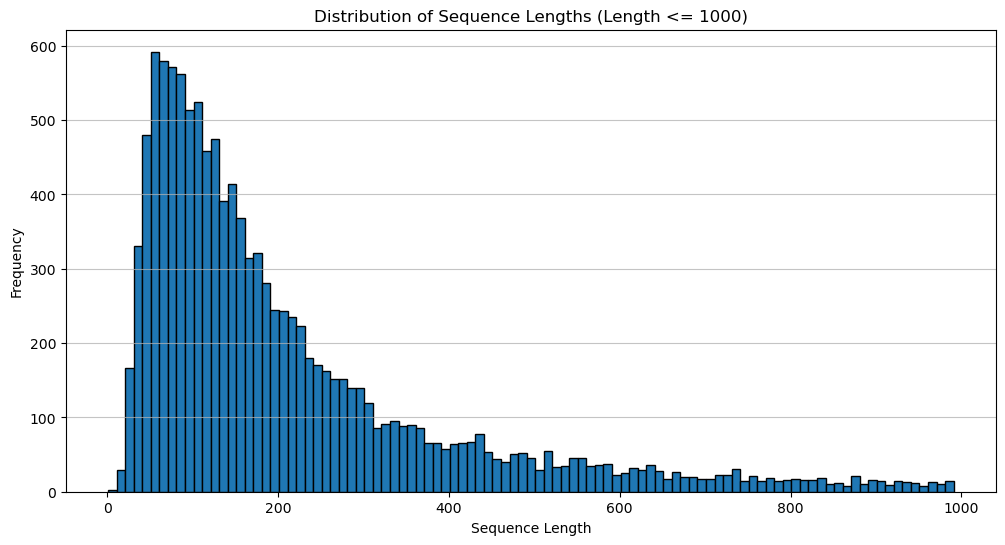

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 读取 Coroheart_Dataset.csv 文件
dataset = pd.read_csv('output/Coroheart_Dataset.csv')

# 初始化序列列表和计数器
sequences = []
current_sequence = []

# 遍历数据，识别序列
for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0], desc="Processing sequences"):
    if row['k'] == 'Goal event':
        if current_sequence:  # 如果当前序列不为空，保存当前序列的长度
            sequences.append(len(current_sequence))
            current_sequence = []  # 重置当前序列
    else:
        current_sequence.append(row)  # 添加到当前序列

# 处理最后一个序列（如果存在）
if current_sequence:
    sequences.append(len(current_sequence))

# 打印序列数量
print(f"总共有 {len(sequences)} 个序列")

# 画直方图时过滤掉长度大于 1000 的序列
filtered_sequences = [length for length in sequences if length <= 1000]

# 绘制直方图
plt.figure(figsize=(12, 6))
plt.hist(filtered_sequences, bins=range(1, 1001, 10), edgecolor='black')  # 横距为 10
plt.title('Distribution of Sequence Lengths (Length <= 1000)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [2]:
import pandas as pd

# 读取 Stroke_Dataset.csv 文件，跳过第一行
stroke_data = pd.read_csv('output/Coroheart_Dataset.csv', header=None, names=['id', 't', 'v', 'k'], skiprows=1)

# 将 t 列转换为浮点数
stroke_data['t'] = stroke_data['t'].astype(float)

# 初始化变量
sequences = []
current_sequence = []

# 遍历数据，识别序列
for index, row in stroke_data.iterrows():
    if row['k'] == 'Goal event':
        if current_sequence:  # 如果当前序列不为空
            sequences.append(current_sequence)
        current_sequence = [row]  # 开始新的序列
    else:
        current_sequence.append(row)  # 添加到当前序列

# 处理最后一个序列（如果存在）
if current_sequence:
    sequences.append(current_sequence)

# 过滤掉时间跨度超过 14*24 小时的序列和长度小于2的序列
filtered_sequences = []
for seq in sequences:
    if len(seq) >= 2 and (seq[-1]['t'] - seq[0]['t'] <= 14 * 24):
        filtered_sequences.append(seq)

# 将过滤后的序列展平为 DataFrame
filtered_data = pd.DataFrame([item for sublist in filtered_sequences for item in sublist])

# 保存结果到 StrokeDatasets.csv
output_file_path = 'output/CoroheartDatasets.csv'
filtered_data.to_csv(output_file_path, index=False, header=False)

# 计算序列统计信息
sequence_lengths = [len(seq) for seq in filtered_sequences]
num_sequences = len(filtered_sequences)
average_length = sum(sequence_lengths) / num_sequences if num_sequences > 0 else 0
min_length = min(sequence_lengths) if sequence_lengths else 0
max_length = max(sequence_lengths) if sequence_lengths else 0

# 打印结果
print(f"处理后 CoroheartDatasets.csv 的序列数量: {num_sequences}")
print(f"平均序列长度: {average_length:.2f}")
print(f"序列长度范围: [{min_length}, {max_length}]")

处理后 CoroheartDatasets.csv 的序列数量: 12459
平均序列长度: 282.45
序列长度范围: [6, 7055]


In [4]:
import pandas as pd

# 读取 StrokeDatasets.csv 文件
stroke_datasets = pd.read_csv('output/CoroheartDatasets.csv')

# 过滤掉 k 值为 Middle_to_Sever 的数据
filtered_datasets = stroke_datasets[stroke_datasets['k'] != 'Goal event']

# 统计不同的 k 值数量
unique_k_count = filtered_datasets['k'].nunique()

# 打印所有的 k 值
print("在 CoroheartDatasets.csv 中所有的事件类型为:", filtered_datasets['k'].unique())

# 打印结果
print(f"在 CoroheartDatasets.csv 中事件类型数量为: {unique_k_count}")

在 CoroheartDatasets.csv 中所有的事件类型为: ['Heart Rate High' 'Respiratory Rate High' 'Temperature Fahrenheit Low'
 'Albumin Low' 'C Reactive Protein High' 'Hemoglobin Low' 'AST High'
 'LDH High' 'BUN High' 'Calcium non-ionized High' 'Potassium High'
 'White Blood Cells High' 'Respiratory Rate Low'
 'Temperature Fahrenheit High' 'Creatinine High' 'Glucose High' 'CK Low'
 'O2 saturation pulseoxymetry Low' 'ALT High' 'Sodium High'
 'Anion gap High' 'Potassium Low' 'Glucose Low' 'Sodium Low'
 'Heart Rate Low' 'Brain Natiuretic Peptide High' 'Platelet Count Low'
 'CK High' 'Lactic Acid High' 'Arterial Blood Pressure diastolic Low'
 'Arterial Blood Pressure mean Low'
 'Arterial Blood Pressure systolic High'
 'Arterial Blood Pressure systolic Low'
 'Arterial Blood Pressure diastolic High' 'Hematocrit Low'
 'Arterial Blood Pressure mean High' 'INR High' 'CK-MB fraction High'
 'Creatinine Low' 'Platelet Count High' 'White Blood Cells Low'
 'Anion gap Low' 'BUN Low' 'AST Low' 'ALT Low' 'Total Bilirubin

In [1]:
import pandas as pd

df = pd.read_csv('./output/CoroheartDatasets.csv')

# 提取所有不同的k值，并跳过值为Goal event的项
unique_k_values = df['k'].unique()

unique_k_values = [k for k in unique_k_values if k != 'Goal event']

result_df = pd.DataFrame({
    'body_pred': unique_k_values,
    'index': range(len(unique_k_values))
})

result_df.to_csv('Coroheart_Body_Pred.csv', index=False)
print(result_df)


d:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


                                 body_pred  index
0                          Heart Rate High      0
1                    Respiratory Rate High      1
2               Temperature Fahrenheit Low      2
3                              Albumin Low      3
4                  C Reactive Protein High      4
5                           Hemoglobin Low      5
6                                 AST High      6
7                                 LDH High      7
8                                 BUN High      8
9                 Calcium non-ionized High      9
10                          Potassium High     10
11                  White Blood Cells High     11
12                    Respiratory Rate Low     12
13             Temperature Fahrenheit High     13
14                         Creatinine High     14
15                            Glucose High     15
16                                  CK Low     16
17         O2 saturation pulseoxymetry Low     17
18                                ALT High     18


In [2]:
import pandas as pd

# 读取 CoroheartDatasets.csv 文件
stroke_data = pd.read_csv('output/CoroheartDatasets.csv')

# 提取唯一的 id
unique_ids = stroke_data['id'].unique()

# 计算分割点
split_index = int(len(unique_ids) * 0.8)

# 分割 id 为 ids1 和 ids2
ids1 = unique_ids[:split_index]
ids2 = unique_ids[split_index:]

# 根据 ids1 和 ids2 过滤数据
stroke_train = stroke_data[stroke_data['id'].isin(ids1)]
stroke_test = stroke_data[stroke_data['id'].isin(ids2)]

# 保存结果到 StrokeTrain.csv 和 StrokeTest.csv
stroke_train.to_csv('CoroheartTrain.csv', index=False)
stroke_test.to_csv('CoroheartTest.csv', index=False)

print(f"CoroheartTrain.csv 和 CoroheartTest.csv 已保存。")

CoroheartTrain.csv 和 CoroheartTest.csv 已保存。


In [3]:
import pandas as pd

test_df = pd.read_csv('CoroheartTest.csv')
train_df = pd.read_csv('CoroheartTrain.csv')
body_pred_df = pd.read_csv('Coroheart_Body_Pred.csv')

# 创建一个字典用于查找 body_pred 对应的 index
body_pred_to_index = body_pred_df.set_index('body_pred')['index'].to_dict()

# 定义一个函数来查找 index
def find_index(row):
    return body_pred_to_index.get(row['k'], None)

# 在 test 和 train 数据集中添加 index 列
test_df['index'] = test_df.apply(find_index, axis=1)
train_df['index'] = train_df.apply(find_index, axis=1)

test_df.to_csv('CoroheartTestIndex.csv', index=False)
train_df.to_csv('CoroheartTrainIndex.csv', index=False)

In [4]:
# 此处检查一下，是否存在 k 值不为 '1/2transfer3' 且 index 为 null 的行
test_index_df = pd.read_csv('CoroheartTestIndex.csv')
train_index_df = pd.read_csv('CoroheartTrainIndex.csv')

# 筛选出 k 值不为 '1/2transfer3' 且 index 为 null 的行
test_null_rows = test_index_df[(test_index_df['k'] != 'Goal event') & (test_index_df['index'].isnull())]
train_null_rows = train_index_df[(train_index_df['k'] != 'Goal event') & (train_index_df['index'].isnull())]

print(f"Test file null rows count: {len(test_null_rows)}")
print(f"Train file null rows count: {len(train_null_rows)}")

Test file null rows count: 0
Train file null rows count: 0


In [3]:
import numpy as np
import pandas as pd

# 定义一个非常大的数，如果一个谓词对应的事件没有发生，则用一个很大的数来表示
large_number = 1e10

def process_dataframe(file_path, output_path):
    df = pd.read_csv(file_path)
    
    result = []
    group = []
    for _, row in df.iterrows():
        if row['k'] == 'Goal event':
            # 如果这一组的k值为Goal event的那一行的t值为99999，则删掉这一组
            if row['t'] == 99999.0:
                group = []
                continue
            # 处理当前组
            if group:
                group_id = group[0]['id']
                # 初始化 body_predicates_time 数组
                body_predicates_time = [large_number] * 56
                # 填充 body_predicates_time 数组
                for item in group:
                    index = int(item['index'])
                    body_predicates_time[index] = item['t']
                # If body_predicates_time is all large_number, skip this group
                if all(time == large_number for time in body_predicates_time):
                    continue
                # 获取 head_predicate_time
                head_predicate_time = [row['t']]
                # 添加到结果
                result.append({
                    'id': group_id,
                    'body_predicates_time': body_predicates_time,
                    'head_predicate_time': head_predicate_time
                })
            group = []
        else:
            group.append(row)
    
    np.save(output_path, result)
    # 输出分组数
    print(f"{file_path} 数据集总共有 {len(result)} 组")
    # 打印前两个结果
    print(f"前两个结果: {result[:2]}")

# 处理测试集和训练集
process_dataframe('CoroheartTestIndex.csv', 'CoroheartTestData.npy')
process_dataframe('CoroheartTrainIndex.csv', 'CoroheartTrainData.npy')


CoroheartTestIndex.csv 数据集总共有 367 组
前两个结果: [{'id': 37967322, 'body_predicates_time': [10000000000.0, 351.9833333333333, 352.7333333333333, 265.5, 10000000000.0, 350.6666666666667, 10000000000.0, 121.55, 265.5, 265.5, 216.46666666666667, 265.5, 352.7333333333333, 221.7333333333333, 265.5, 265.5, 10000000000.0, 276.7333333333333, 10000000000.0, 10000000000.0, 71.31666666666666, 232.88333333333333, 10000000000.0, 265.5, 351.9833333333333, 10000000000.0, 145.31666666666666, 10000000000.0, 10000000000.0, 273.7333333333333, 270.7333333333333, 273.7333333333333, 244.7333333333333, 227.7333333333333, 350.6666666666667, 227.7333333333333, 48.2, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 156.55, 10000000000.0, 10000000000.0, 265.5, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0], 'head_predicate_time': [871.6833333333333]}, {'id': 37970920, 'body_predicates_time':

In [1]:
import numpy as np

# 加载 .npy 文件
train_data = np.load('CoroheartTrainData.npy', allow_pickle=True)
test_data = np.load('CoroheartTestData.npy', allow_pickle=True)

def filter_data(data):
    filtered_data = []
    for group in data:
        # 假设每组数据是一个字典，包含 'id', 'body_predicates_time', 'head_predicate_time'
        body_predicates_time = group['body_predicates_time']
        head_predicate_time = float(group['head_predicate_time'][0])  # 将 head_predicate_time 转换为数字
        
        # 找到 body_predicates_time 中的最大值，且不等于 10000000000.0
        max_body_time = max(float(time) for time in body_predicates_time if float(time) != 10000000000.0)  # 将 body_predicates_time 中的值转换为数字
        
        # 检查条件
        if max_body_time + 24 >= head_predicate_time:
            filtered_data.append(group)
    
    return filtered_data

# 过滤数据
filtered_train_data = filter_data(train_data)
filtered_test_data = filter_data(test_data)

# 保存过滤后的数据
np.save('CoroheartTrain.npy', filtered_train_data)
np.save('CoroheartTest.npy', filtered_test_data)

# 打印结果
print(f"CoroheartTrain.npy 中的组数: {len(filtered_train_data)}")
print(f"CoroheartTest.npy 中的组数: {len(filtered_test_data)}")

# 打印前两个组
print("CoroheartTrain.npy 前两个组:", filtered_train_data[:2])
print("CoroheartTest.npy 前两个组:", filtered_test_data[:2])

CoroheartTrain.npy 中的组数: 947
CoroheartTest.npy 中的组数: 269
CoroheartTrain.npy 前两个组: [{'id': 30008792, 'body_predicates_time': [127.38333333333334, 127.43333333333334, 10000000000.0, 14.966666666666669, 10000000000.0, 108.4, 14.966666666666669, 10000000000.0, 108.4, 108.4, 10000000000.0, 38.98333333333333, 127.46666666666668, 126.06666666666666, 108.4, 108.4, 108.4, 127.45, 10000000000.0, 10000000000.0, 38.98333333333333, 10000000000.0, 10000000000.0, 10000000000.0, 127.46666666666668, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 127.06666666666666, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 60.46666666666667, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0], 'head_predicate_time': [127.75]}, {'i